# T20 Cricket Final Score Prediction using Neural Networks
This notebook focuses on making a Machine Learning Model that is able to make Final Score Predictions in T20 format.

## Packages
The first step is to import the relevant packages.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import tensorflow as tf
np.random.seed(42)
%matplotlib inline

## Activation Functions
The next step is to define the activation functions that we will be using in the neural network

In [2]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z)) 
        
def relu(Z):
    return np.maximum(0, Z)

def tanh(Z):
    return np.tanh(Z)
    
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis = 0, keepdims = True)
    

## Neural Network
Now we have to make the neural network. Here, I have chosen an OOP based approach, so that I can keep my models separate, so that the parameters of one model don't interfere with the parameters of another model. It also makes it easier to manage them.

In [3]:
class Neural_network():
    '''
    Class for a neural network.
    '''
    
    def __init__(self, layer_sizes, layer_activations, learning_rate, epochs, dropout = 1, beta1 = 0.9, beta2 = 0.999, 
                 epsilon = 1e-8):
        '''
        initialize the neural network.
        '''
        self.layer_sizes = layer_sizes
        self.layer_activations = layer_activations
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.epochs = epochs
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.accuracy = 20
        self.train_costs = []
        self.dev_costs = []
        
        # Initialize parameters of each layer
        self.params = {}
        for i in range(1, len(layer_sizes)):
            self.params['W' + str(i)] = np.random.randn(layer_sizes[i], layer_sizes[i - 1]) * 0.01
            self.params['b' + str(i)] = np.zeros((layer_sizes[i], 1))
            
        # Initialize velocity and stuff for Adam
        self.v = {}
        self.s = {}
        
        for i in range(1, len(layer_sizes)):

            self.v["dW" + str(i)] = np.zeros(self.params["W" + str(i)].shape)
            self.v["db" + str(i)] = np.zeros(self.params["b" + str(i)].shape)
            self.s["dW" + str(i)] = np.zeros(self.params["W" + str(i)].shape)
            self.s["db" + str(i)] = np.zeros(self.params["b" + str(i)].shape)
            
            
    def forward_prop(self, X, dropout = False):
        '''
        Performs forward propagation for an iteration.
        '''
        
        A_prev = X
        Z = [0]
        A = [A_prev]
        self.D = []
        
        for i in range(1, len(self.layer_sizes)):
            
            Zi = np.dot(self.params['W' + str(i)], A_prev) + self.params['b' + str(i)]
            if self.layer_activations[i - 1] == 'sigmoid':
                A_prev = sigmoid(Zi)
            elif self.layer_activations[i - 1] == 'relu':
                A_prev = relu(Zi)
            elif self.layer_activations[i - 1] == 'tanh':
                A_prev = tanh(Zi)
            elif self.layer_activations[i - 1] == 'linear':
                A_prev = Zi
            elif self.layer_activations[i - 1] == 'softmax':
                A_prev = softmax(Zi)

            # Don't apply dropout on output layer
            if i != len(self.layer_sizes) - 1 and dropout:
            # Apply dropout 
                Di = np.random.rand(A_prev.shape[0], A_prev.shape[1])
                Di = (Di < self.dropout).astype(int)
                A_prev = A_prev * Di
                A_prev = A_prev / self.dropout
                self.D.append(Di)
            
            A.append(A_prev)
            Z.append(Zi)

        return A, Z
    
    
    def compute_cost(self, Y, Y_hat):
        '''
        Computes the cost of an iteration
        '''
        
        m = Y.shape[1]
        
        if self.layer_activations[-1] == 'sigmoid':
            cost = - np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat)) / m 
        elif self.layer_activations[-1] == 'linear':
            cost = np.sum((Y_hat - Y) ** 2) / (2 * m)
        elif self.layer_activations[-1] == 'softmax':
            cost = - np.sum(Y * np.log(Y_hat)) / m
        
        return np.squeeze(cost)
    
    
    def back_prop(self, X, Y, A, Z):
        m = X.shape[1]
        grads = {}
        L = len(self.layer_sizes) - 1
        
        if self.layer_activations[-1] == 'sigmoid':
            dAL = - (np.divide(Y, A[-1]) - np.divide(1 - Y, 1 - A[-1]))
            dZL = A[-1] * (1 - A[-1]) * dAL
        elif self.layer_activations[-1] == 'linear':
            dAL = A[-1] - Y
            dZL = dAL
        elif self.layer_activations[-1] == 'softmax':
            dAL = - Y / A[-1]
            
        A_prev = A[-2]
        
        grads['dW' + str(L)] = np.dot(dZL, A_prev.T) / m
        grads['db' + str(L)] = np.sum(dZL, axis = 1, keepdims = True) / m
        dA_prev = np.dot(self.params['W' + str(L)].T, dZL)
        
        for i in reversed(range(L - 1)):

            dA_prev = dA_prev * self.D[i]
            dA_prev = dA_prev / self.dropout
            Zi = Z[i + 1]
            if self.layer_activations[i] == 'sigmoid':
                dZl = A_prev * (1 - A_prev) * dA_prev
            elif self.layer_activations[i] == 'relu': 
                dZl = np.array(dA_prev, copy=True)
                dZl[Zi <= 0] = 0
            elif self.layer_activations[i] == 'tanh':
                dZl = (1 - A_prev) * dA_prev

            A_prev = A[i]
            
            grads['dW' + str(i + 1)] = np.dot(dZl, A_prev.T) / m
            grads['db' + str(i + 1)] = np.sum(dZl, axis=1, keepdims=True) / m
            dA_prev = np.dot(self.params['W' + str(i + 1)].T, dZl)
            
        return grads
    

    def fit(self, X_train, Y_train, X_dev, Y_dev):
        train_cost = 0
        dev_cost = 0
        for epoch in range(self.epochs):
            A, Z = self.forward_prop(X_train, True)
            train_cost = self.compute_cost(Y_train, A[-1])
            grads = self.back_prop(X_train, Y_train, A, Z)
            self.update_params(grads, epoch + 1)
            self.train_costs.append(train_cost)

            Ad, _ = self.forward_prop(X_dev)
            dev_cost = self.compute_cost(Y_dev, Ad[-1])
            self.dev_costs.append(dev_cost)
            
            if epoch % 100 == 0:
                print(f"Cost at epoch {epoch} is: Train: {train_cost}, Dev: {dev_cost}")
        print(f"Final cost is: Train: {train_cost}, Dev: {dev_cost}")        
        plt.plot(self.train_costs, label = "Train")
        plt.plot(self.dev_costs, label = "Dev")
        plt.xlabel("epochs")
        plt.ylabel("cost")
        plt.legend()

        A, Z = self.forward_prop(X_train)
        Ad, _ = self.forward_prop(X_dev)
        train_acc = np.sum((np.abs(Y_train - A[-1]) < self.accuracy)) / Y_train.shape[1]
        dev_acc = np.sum((np.abs(Y_dev - Ad[-1]) < self.accuracy)) / Y_dev.shape[1]
        print(f"The accuracy on train set is : {train_acc * 100:.2f} %")
        print(f"The accuracy on dev set is : {dev_acc * 100: .2f} %")
        
    
    def update_params(self, grads, t):
        # Correction for moving averages
        self.v_corrected = {}            
        self.s_corrected = {} 
        for i in range(1, len(self.layer_sizes)):
            self.v["dW" + str(i)] = self.beta1 * self.v["dW" + str(i)] + (1 - self.beta1) * grads["dW" + str(i)]
            self.v["db" + str(i)] = self.beta1 * self.v["db" + str(i)] + (1 - self.beta1) * grads["db" + str(i)]   
            
            # Bias correction
            self.v_corrected["dW" + str(i)] = self.v["dW" + str(i)] / (1 - self.beta1 ** t)
            self.v_corrected["db" + str(i)] = self.v["db" + str(i)] / (1 - self.beta1 ** t)
            
            # Almost same stuff as v, just with square
            self.s["dW" + str(i)] = self.beta2 * self.s["dW" + str(i)] + (1 - self.beta2) * (grads["dW" + str(i)] ** 2)
            self.s["db" + str(i)] = self.beta2 * self.s["db" + str(i)] + (1 - self.beta2) * (grads["db" + str(i)] ** 2) 
            
            self.s_corrected["dW" + str(i)] = self.s["dW" + str(i)] / (1 - self.beta2 ** t)
            self.s_corrected["db" + str(i)] = self.s["db" + str(i)] / (1 - self.beta2 ** t)
            
            self.params['W' + str(i)] -= self.learning_rate * (self.v_corrected['dW' + str(i)] / np.sqrt(self.s_corrected['dW' + str(i)] + self.epsilon))
            self.params['b' + str(i)] -= self.learning_rate * (self.v_corrected['db' + str(i)] / np.sqrt(self.s_corrected['db' + str(i)] + self.epsilon))
            
            
    def test(self, X, Y):
        A, _ = self.forward_prop(X)
        cost = self.compute_cost(Y, A[-1])
        print(f"The cost on test set is {cost}")
        test_acc = np.sum((np.abs(Y - A[-1]) < self.accuracy)) / Y.shape[1]
        print(f"The accuracy on test set is : {test_acc * 100:.2f} %")
        
        return
        
        
    def predict(self, X):
        A, _ = self.forward_prop(X)
        return A[-1]
       

## Testing the Model
The following cell shows that my model works perfectly, and it is able to reduce costs.

Cost at epoch 0 is: Train: 18.519627006319766, Dev: 18.46014963365396
Cost at epoch 100 is: Train: 3.8259841127798393, Dev: 3.680379625961785
Cost at epoch 200 is: Train: 0.26879010488184113, Dev: 0.2678535914202167
Cost at epoch 300 is: Train: 0.17992023506986649, Dev: 0.17910227251150748
Cost at epoch 400 is: Train: 0.10774724804196874, Dev: 0.10713167955801818
Cost at epoch 500 is: Train: 0.05703622755859075, Dev: 0.0566369255508478
Cost at epoch 600 is: Train: 0.026382043593556857, Dev: 0.02616080974679298
Cost at epoch 700 is: Train: 0.010584049385600182, Dev: 0.010480174358329873
Cost at epoch 800 is: Train: 0.0036760008563008926, Dev: 0.0036347048646721597
Cost at epoch 900 is: Train: 0.0011079370456123418, Dev: 0.0010939595030087222
Final cost is: Train: 0.00029502273163195135, Dev: 0.000290908428177658
The accuracy on train set is : 100.00 %
The accuracy on dev set is :  100.00 %
[[6.0032158]]


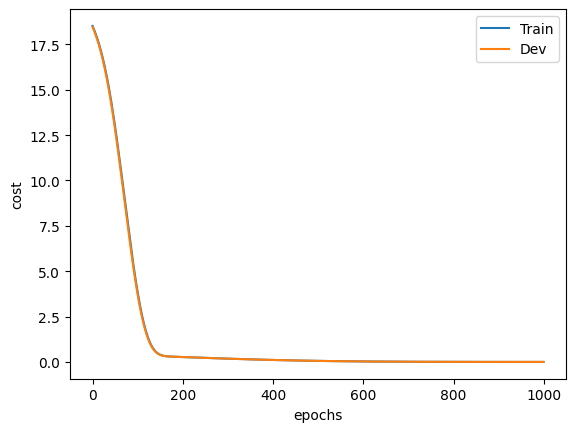

In [39]:
# Generate synthetic data
X_train = np.random.rand(1, 100)
Y_train = 6 * X_train + 3

# Create and train the neural network
model = Neural_network(layer_sizes=[1, 3, 1], layer_activations=['relu', 'linear'], learning_rate=0.01, epochs=1000)
costs = model.fit(X_train, Y_train, X_train, Y_train)

# Test the model
X_test = np.array([[0.5]])
predicted_y = model.predict(X_test)
print(predicted_y)

## Load the Data

In [40]:
# Read the match data csv
match_data = pd.read_csv(r"../Resources/final_score_data.csv")
match_data.head()

,total balls,score,Total Wickets,final score,Afghanistan,Argentina,Australia,Austria,Bahamas,Bahrain,...,Switzerland,Tanzania,Thailand,Turkey,Uganda,United Arab Emirates,United States of America,Vanuatu,West Indies,Zimbabwe
0,0,0,0,121,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4,0,121,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,4,0,121,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,4,0,121,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,5,0,121,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
country_list = ['Afghanistan', 'Argentina', 'Australia', 'Austria', 'Bahamas', 'Bahrain', 'Bangladesh', 'Belgium', 'Belize', 'Bermuda', 'Bhutan', 'Botswana', 'Bulgaria', 'Cameroon', 'Canada', 'Cayman Islands', 'Cook Islands', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'England', 'Estonia', 'Eswatini', 'Fiji', 'Finland', 'France', 'Gambia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Guernsey', 'Hong Kong', 'Hungary', 'ICC World XI', 'India', 'Indonesia', 'Iran', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Japan', 'Jersey', 'Kenya', 'Kuwait', 'Lesotho', 'Luxembourg', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mozambique', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Oman', 'Pakistan', 'Panama', 'Papua New Guinea', 'Philippines', 'Portugal', 'Qatar', 'Romania', 'Rwanda', 'Samoa', 'Saudi Arabia', 'Scotland', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sri Lanka', 'St Helena', 'Swaziland', 'Sweden', 'Switzerland', 'Tanzania', 'Thailand', 'Turkey', 'Uganda', 'United Arab Emirates', 'United States of America', 'Vanuatu', 'West Indies', 'Zimbabwe']

print(len(country_list))
def one_hot(target_country):
    '''
    This function takes a country, and returns a one hot encoded np array
    '''
    one_hot_encoded = [int(country == target_country) for country in country_list]
    return np.array(one_hot_encoded)


95


# Training the model
Now I convert the relevant data into numpy arrays, divide it into train, dev and test sets in a ratio of 96/2/2 (since I have a lot of data), and feed them into a model. My first model is a simple linear regression model so that I can set the baseline for accuracy.

In [42]:
# Specify the X and Y labels
Y = match_data[["final score"]].to_numpy()
match_data = match_data.drop(columns=["final score"])
X = match_data.to_numpy()
scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(X)
X = X.T
Y = Y.T
print(X.shape)
print(Y.shape)

(98, 407789)
(1, 407789)


In [43]:
# Split into train/dev and test sets
train_ratio = 0.96
dev_ratio = 0.02
# Test and dev ratio are same

total_examples = X.shape[1]
train_size = int(train_ratio * total_examples)
dev_size = int(dev_ratio * total_examples)


# Shuffle the arrays
indices = np.random.permutation(total_examples)
X, Y = X[:,indices], Y[:,indices]
#X, Y = X[indices], Y[indices]

# Finally, split the data
X_train, X_dev, X_test = X[:,:train_size], X[:,train_size:train_size + dev_size], X[:, train_size + dev_size:]
Y_train, Y_dev, Y_test = Y[:,:train_size], Y[:,train_size:train_size + dev_size], Y[:, train_size + dev_size:]
#X_train, X_dev, X_test = X[:train_size], X[train_size:train_size + dev_size], X[train_size + dev_size:]
#Y_train, Y_dev, Y_test = Y[:train_size], Y[train_size:train_size + dev_size], Y[train_size + dev_size:]



Cost at epoch 0 is: Train: 11071.382149022735, Dev: 10834.270418351425
Cost at epoch 100 is: Train: 3000.2785705193683, Dev: 2903.3151930010204
Cost at epoch 200 is: Train: 1135.7234131840319, Dev: 1098.7615526767377
Cost at epoch 300 is: Train: 842.6016035396686, Dev: 821.5870363450355
Cost at epoch 400 is: Train: 743.0468748207246, Dev: 727.1053496410423
Cost at epoch 500 is: Train: 670.6618810908301, Dev: 657.4810630446995
Cost at epoch 600 is: Train: 612.782597795826, Dev: 601.558501242578
Cost at epoch 700 is: Train: 567.0407352273222, Dev: 557.3192341136017
Cost at epoch 800 is: Train: 531.7075394917879, Dev: 523.1949978568219
Cost at epoch 900 is: Train: 504.92455740994893, Dev: 497.4248194006175
Final cost is: Train: 484.98099889483984, Dev: 478.34599318915394
The accuracy on train set is : 51.43 %
The accuracy on dev set is :  51.93 %
The cost on test set is 496.58922458015184
The accuracy on test set is : 50.66 %


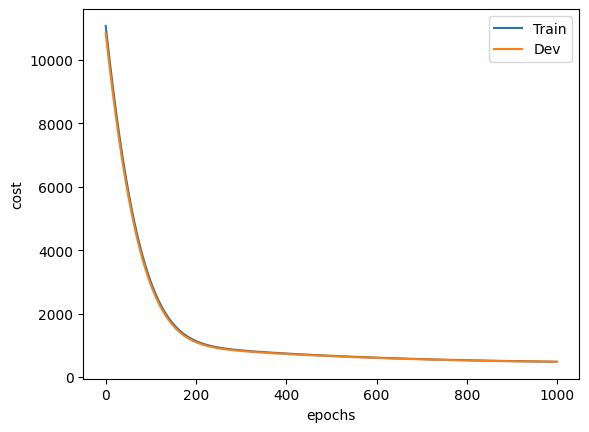

In [44]:
# Now create and train the model
final_score_predictor = Neural_network(layer_sizes=[98, 1], layer_activations=['linear'], 
                                      learning_rate = 0.3, epochs = 1000)

final_score_predictor.fit(X_train, Y_train, X_dev, Y_dev)
final_score_predictor.test(X_test, Y_test)

Cost at epoch 0 is: Train: 385.7957606894932, Dev: 385.91072913282784
Cost at epoch 100 is: Train: 385.0709098051615, Dev: 385.23192406745625
Cost at epoch 200 is: Train: 383.8633584365719, Dev: 384.09662088347505
Cost at epoch 300 is: Train: 382.33765968213373, Dev: 382.6623045215685
Cost at epoch 400 is: Train: 380.5913664827947, Dev: 381.0191764432271
Cost at epoch 500 is: Train: 378.69206426515495, Dev: 379.23023610166405
Cost at epoch 600 is: Train: 376.69327572494046, Dev: 377.3459004691589
Cost at epoch 700 is: Train: 374.6402756702328, Dev: 375.4092621826244
Cost at epoch 800 is: Train: 372.57255464749363, Dev: 373.4582184154384
Cost at epoch 900 is: Train: 370.52479994566534, Dev: 371.52622873768587
Final cost is: Train: 368.54683744468826, Dev: 369.6609852360409
The accuracy on train set is : 61.09 %
The accuracy on dev set is :  60.76 %
The cost on test set is 371.4540839009115
The accuracy on test set is : 60.76 %


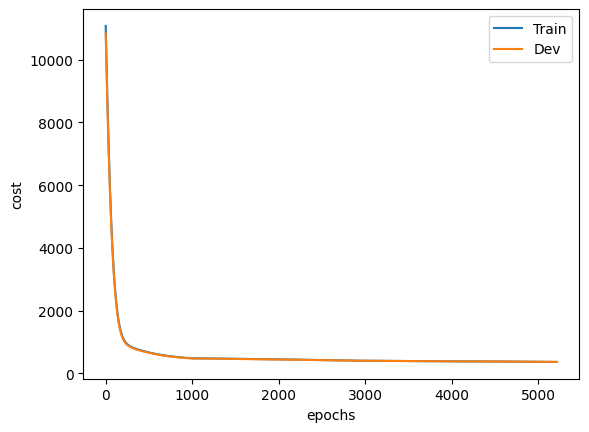

In [49]:
# Train the model more to make fine adjustments
final_score_predictor.learning_rate = 0.3
final_score_predictor.epochs = 1000
final_score_predictor.fit(X_train, Y_train, X_dev, Y_dev)
final_score_predictor.test(X_test, Y_test)

### Result
So I got an accuracy of about 64% on the linear model, Let's try a slightly more complex model

Cost at epoch 0 is: Train: 11070.237683184452, Dev: 10959.059762329147
Cost at epoch 100 is: Train: 482.7601117804355, Dev: 477.63615683662414
Cost at epoch 200 is: Train: 399.60709983347215, Dev: 398.60152085364314
Cost at epoch 300 is: Train: 375.4080022838326, Dev: 376.25499170797474
Cost at epoch 400 is: Train: 356.27269990437105, Dev: 358.43692787822084
Cost at epoch 500 is: Train: 343.5467127308789, Dev: 346.9936129179779
Cost at epoch 600 is: Train: 339.73079407439593, Dev: 344.00340914086513
Cost at epoch 700 is: Train: 338.78201455370714, Dev: 343.2170873091071
Cost at epoch 800 is: Train: 338.07381458778184, Dev: 342.33062024335214
Cost at epoch 900 is: Train: 336.63758083145893, Dev: 341.15685413244006
Final cost is: Train: 336.3496615233333, Dev: 341.01120260669836
The accuracy on train set is : 65.13 %
The accuracy on dev set is :  65.09 %
The cost on test set is 337.9685504657518
The accuracy on test set is : 64.36 %


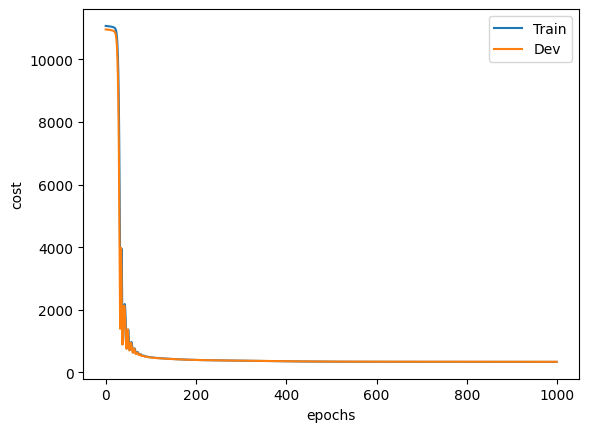

In [57]:
# Training model no 2
final_score_predictor2 = Neural_network(layer_sizes=[98,75,50,25,12,6,5,4,1], layer_activations=['relu','relu','relu','relu','relu','relu','relu','linear'], 
                                      learning_rate = 0.01, epochs = 1000, dropout = 1)

final_score_predictor2.fit(X_train, Y_train, X_dev, Y_dev)
final_score_predictor2.test(X_test, Y_test)

Cost at epoch 0 is: Train: 336.326438677652, Dev: 341.0029827285547
Final cost is: Train: 336.326438677652, Dev: 341.0029827285547
The accuracy on train set is : 65.14 %
The accuracy on dev set is :  65.11 %
The cost on test set is 337.9547976129548
The accuracy on test set is : 64.41 %


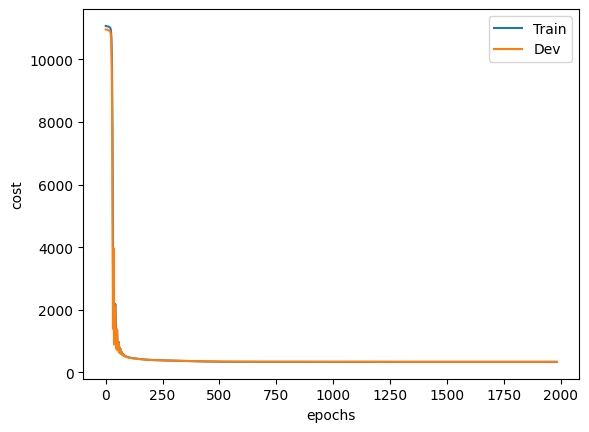

In [59]:
# Train the model more to make fine adjustments
final_score_predictor2.learning_rate = 0.0001
final_score_predictor2.epochs = 1
final_score_predictor2.fit(X_train, Y_train, X_dev, Y_dev)
final_score_predictor2.test(X_test, Y_test)

In [62]:
r2_score(Y_test.T, final_score_predictor2.predict(X_test).T)

0.5134036085472455

In [64]:
predicted_score = round(float(final_score_predictor2.predict(scaler.transform(np.concatenate([[114,80,5],one_hot("Pakistan")]).reshape(1,-1)).reshape(-1, 1))))
print(f"The model predicts a final score of {predicted_score}")

The model predicts a final score of 96


65% accuracy, That's some progress. I guess I can't do anymore. Let's try a third model with country ratings instead of one hot encoding

<h1>Model with country ratings</h1>

In [189]:
# Load The data
country_data = pd.read_csv(r"../Resources/final_score_country.csv")
country_data.head()

,total balls,score,Total Wickets,final score,country rating
0,0,0,0,121,58
1,1,4,0,121,58
2,2,4,0,121,58
3,3,4,0,121,58
4,4,5,0,121,58


In [190]:
# Specify the X and Y labels
Y = country_data[["final score"]].to_numpy()
X = country_data[['total balls','score','Total Wickets','country rating']].to_numpy()
X = X
Y = Y
print(X.shape)
print(Y.shape)

# Split into train/dev and test sets
train_ratio = 0.96
dev_ratio = 0.02
# Test and dev ratio are same

total_examples = X.shape[0]
train_size = int(train_ratio * total_examples)
dev_size = int(dev_ratio * total_examples)


# Shuffle the arrays
indices = np.random.permutation(total_examples)
X, Y = X[indices], Y[indices]

# Finally, split the data
X_train, X_dev, X_test = X[:train_size], X[train_size:train_size + dev_size], X[train_size + dev_size:]
Y_train, Y_dev, Y_test = Y[:train_size], Y[train_size:train_size + dev_size], Y[train_size + dev_size:]

# Filter dev and test data to contain only total balls >= threshold
#threshold = 114
#X_dev, X_test, Y_dev, Y_test  = X_dev[:,X_dev[0] >= threshold], X_test[:,X_test[0] >= threshold], Y_dev[:,X_dev[0] >= threshold], Y_test[:,X_test[0] >= threshold]

#scaler = preprocessing.MinMaxScaler()
#X_train = scaler.fit_transform(X_train)
#X_dev = scaler.transform(X_dev)
#X_test = scaler.transform(X_test)

print(X_train.shape,X_dev.shape,X_test.shape)
print(Y_train.shape,Y_dev.shape,Y_test.shape)

(394983, 4)
(394983, 1)
(379183, 4) (7899, 4) (7901, 4)
(379183, 1) (7899, 1) (7901, 1)


In [ ]:
# So, first lets train a linear model to check base performance
final_score_predictor = Neural_network(layer_sizes=[4, 1], layer_activations=['linear'], 
                                      learning_rate = 0.1, epochs = 1000)

final_score_predictor.fit(X_train, Y_train, X_dev, Y_dev)
final_score_predictor.test(X_test, Y_test)

Cost at epoch 0 is: Train: 370.80997165416045, Dev: 374.43764554297354
Final cost is: Train: 370.80997165416045, Dev: 374.43764554297354
The accuracy on train set is : 62.93 %
The accuracy on dev set is :  62.98 %
The cost on test set is 365.7265247825257
The accuracy on test set is : 62.47 %


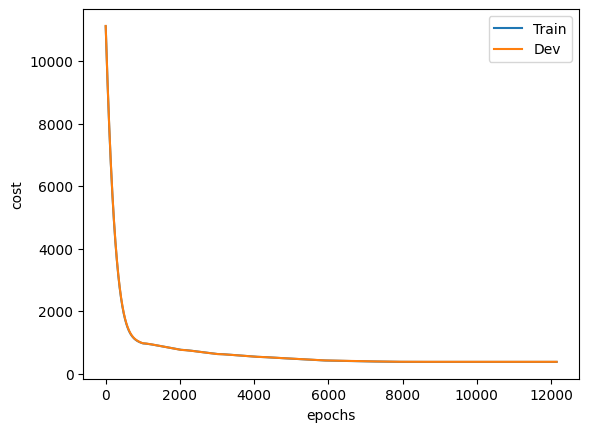

In [83]:
# Train the model more to make fine adjustments
final_score_predictor.learning_rate = 0.0001
final_score_predictor.epochs = 1
final_score_predictor.fit(X_train, Y_train, X_dev, Y_dev)
final_score_predictor.test(X_test, Y_test)

Looks like this is the best I can do, 63% accuracy. Let's try more complex models

Cost at epoch 0 is: Train: 11115.152183762179, Dev: 11021.480135028834
Cost at epoch 100 is: Train: 442.6647559921361, Dev: 440.3329589085566
Cost at epoch 200 is: Train: 389.5237492996461, Dev: 388.80870157873164
Cost at epoch 300 is: Train: 370.8691529259762, Dev: 370.95812008154286
Cost at epoch 400 is: Train: 366.8188336692786, Dev: 366.86530317040234
Cost at epoch 500 is: Train: 364.022226244979, Dev: 363.89466394203174
Cost at epoch 600 is: Train: 363.74647532791016, Dev: 363.7279306004478
Cost at epoch 700 is: Train: 363.6328702028473, Dev: 363.6664010899953
Cost at epoch 800 is: Train: 363.5713457467676, Dev: 363.599154716749
Cost at epoch 900 is: Train: 363.5280604223344, Dev: 363.61642575884974
Final cost is: Train: 363.4927310400113, Dev: 363.6865356819655
The accuracy on train set is : 63.60 %
The accuracy on dev set is :  62.93 %
The cost on test set is 366.34648927110015
The accuracy on test set is : 64.38 %


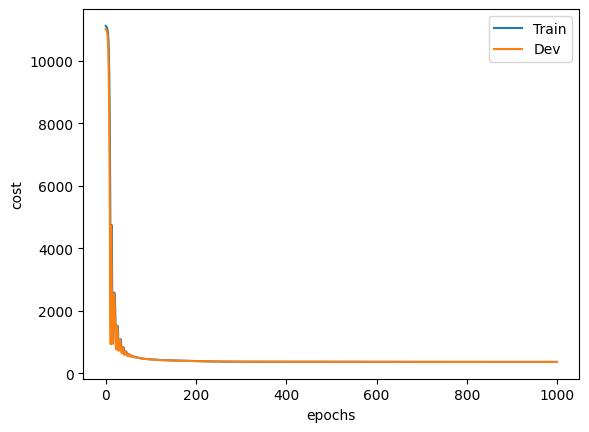

In [163]:
# Training model no 2
final_score_predictor2 = Neural_network(layer_sizes=[4,10,7,5,3,1], layer_activations=['relu','relu','relu','relu','relu','linear'], 
                                      learning_rate = 0.1, epochs = 1000, dropout = 1)

final_score_predictor2.fit(X_train, Y_train, X_dev, Y_dev)
final_score_predictor2.test(X_test, Y_test)

Cost at epoch 0 is: Train: 363.92444440346264, Dev: 172.53957202116743
Final cost is: Train: 363.92444440346264, Dev: 172.53957202116743
The accuracy on train set is : 37.76 %
The accuracy on dev set is :  75.59 %
The cost on test set is 60.12162065685009
The accuracy on test set is : 78.29 %
mse: 120.24324131370018
rmse: 10.965547925831165
r2_score: 0.8827175591849913


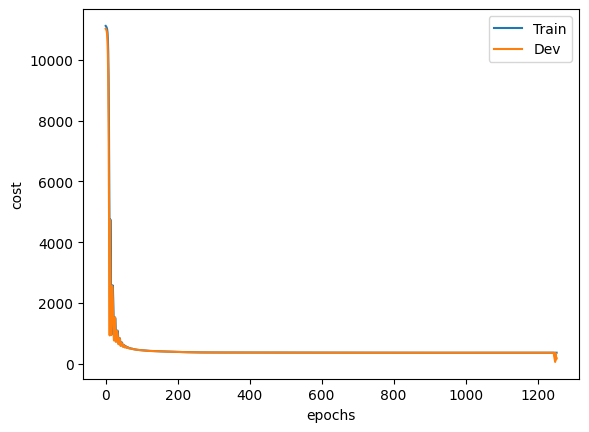

In [184]:
# Train the model more to make fine adjustments
final_score_predictor2.learning_rate = 0.0000001
final_score_predictor2.epochs = 1
final_score_predictor2.accuracy = 10
final_score_predictor2.fit(X_train, Y_train, X_dev, Y_dev)
final_score_predictor2.test(X_test, Y_test)
mse = mean_squared_error(Y_test.T, final_score_predictor2.predict(X_test).T)
print(f"mse: {mse}")
print(f"rmse: {np.sqrt(mse)}")
print(f"r2_score: {r2_score(Y_test.T, final_score_predictor2.predict(X_test).T)}")

In [152]:
predicted_score = round(float(final_score_predictor2.predict(scaler.transform([[114,130,5,254]]).T)))
print(f"The model predicts a final score of {predicted_score}")

The model predicts a final score of 146


In [241]:
final_score_predictor_tf = tf.keras.Sequential ([
    tf.keras.layers.Dense(units = 128,activation='relu',input_dim=4),
    tf.keras.layers.Dense(units = 64,activation='relu'),
    tf.keras.layers.Dense(units = 32,activation='relu'),
    tf.keras.layers.Dense(units = 1),
])

# Compile the model
final_score_predictor_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00005), loss='mean_squared_error', metrics=['mean_squared_error'])

# Print model summary
final_score_predictor_tf.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 128)               640       
                                                                 
 dense_70 (Dense)            (None, 64)                8256      
                                                                 
 dense_71 (Dense)            (None, 32)                2080      
                                                                 
 dense_72 (Dense)            (None, 1)                 33        
                                                                 
Total params: 11009 (43.00 KB)
Trainable params: 11009 (43.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [250]:
final_score_predictor_tf.fit(X_train, Y_train, epochs=1, batch_size=32, validation_data = (X_dev, Y_dev))

11850/11850 [==============================] - 18s 2ms/step - loss: 728.8882 - mean_squared_error: 728.8882 - val_loss: 724.6241 - val_mean_squared_error: 724.6241


In [251]:
final_score_predictor_tf.evaluate(X_test,Y_test)

247/247 [==============================] - 0s 1ms/step - loss: 726.3700 - mean_squared_error: 726.3700


[726.3699951171875, 726.3699951171875]

In [258]:
threshold = 114
accuracy = 10
Y_test_acc = Y_test[X_test[:,0] >= threshold]
predicted_scores = final_score_predictor_tf.predict(X_test)[X_test[:,0] >= threshold]
test_acc = np.sum((np.abs(Y_test_acc - predicted_scores) < accuracy)) / (Y_test_acc.shape[0])
print(f"{test_acc * 100:.2f}")

247/247 [==============================] - 0s 1ms/step
90.19


<h2>Summary</h2>
So, the final model architecture that I will go with is  4 (input) -> 10 -> 7 -> 5 -> 3 -> 1 (output) with relu activations in hidden layers.<br/>
The features used by a model are Here are the results of the model.
<table>
    <thead>
        <th> Threshold </th>
        <th> Accuracy within 20 runs </th>
        <th> Accuracy within 10 runs </th>
        <th> MSE </th>
        <th> RMSE </th> 
        <th> R2 Score </th>
    </thead>
    <tbody>
        <tr>
            <td> None </td>
            <td> 63.31 % </td>
            <td> 38.50 % </td>
            <td> 719.93 </td>
            <td> 26.83 </td> 
            <td> 0.48 </td>
        </tr>
        <tr>
            <td> >5 overs </td>
            <td> 69.36 % </td>
            <td> 43.77 % </td>
            <td> 508.5 </td>
            <td> 22.54 </td> 
            <td> 0.61 </td>
        </tr>
        <tr>
            <td> >10 overs </td>
            <td> 78.61 % </td>
            <td> 52.36 % </td>
            <td> 357.21 </td>
            <td> 18.9 </td> 
            <td> 0.71 </td>
        </tr>
        <tr>
            <td> >15 overs </td>
            <td> 92.40 % </td>
            <td> 66.33 %</td>
            <td> 154.48 </td>
            <td> 12.43 </td> 
            <td> 0.87 </td>
        </tr>
        <tr>
            <td> last over </td>
            <td> 97.36 % </td>
            <td> 78.01 % </td>
            <td> 68.16 </td>
            <td> 8.25 </td> 
            <td> 0.94 </td>
        </tr>
    </tbody>
</table>

<h1>T20 Cricket Final Score Predictor using RNNs</h1>
Now I am going to try out the final score predictor using RNNs

In [4]:
#Load data
rnn_data = pd.read_csv(r"../Resources/rnn_data.csv")
rnn_data

,match code,country,current ball,current score,total wickets,final score,country rating
0,1381452,Austria,0,0,0,121,58
1,1381452,Austria,1,4,0,121,58
2,1381452,Austria,2,4,0,121,58
3,1381452,Austria,3,4,0,121,58
4,1381452,Austria,4,5,0,121,58
...,...,...,...,...,...,...,...
380013,1286672,Belize,115,137,6,143,22
380014,1286672,Belize,116,141,6,143,22
380015,1286672,Belize,117,142,6,143,22
380016,1286672,Belize,118,142,7,143,22


In [5]:
# Group the data by 'match code' and 'country' to represent each inning
innings = rnn_data.groupby(['match code', 'country'])

# Create lists to store input sequences and target outputs
input_sequences = []
target_outputs = []

# Iterate over innings and create sequences
for inning, inning_data in innings:
    # Skip innings with less than 120 balls
    if len(inning_data) < 120:
        continue
    
    # Select relevant features for input sequence
    input_features = inning_data[['current score','total wickets','country rating']].values
    
    # Slice the input features to length 120
    input_features = input_features[:120]
    
    # Get the final score for the inning
    final_score = inning_data['final score'].values[-1]
    
    # Create target output array of shape (120, 1)
    target_output = np.full((120, 1), final_score)
    
    # Append sequences and target outputs to the lists
    input_sequences.append(input_features)
    target_outputs.append(target_output)

X = np.array(input_sequences)
print(X.shape)
Y = np.array(target_outputs)
print(Y.shape)

(1989, 120, 3)
(1989, 120, 1)


In [6]:
# Split into train/dev and test sets
train_ratio = 0.80
dev_ratio = 0.10
# Test and dev ratio are same

total_examples = X.shape[0]
train_size = int(train_ratio * total_examples)
dev_size = int(dev_ratio * total_examples)


# Shuffle the arrays
indices = np.random.permutation(total_examples)
X, Y = X[indices], Y[indices]

# Finally, split the data
X_train, X_dev, X_test = X[:train_size], X[train_size:train_size + dev_size], X[train_size + dev_size:]
Y_train, Y_dev, Y_test = Y[:train_size], Y[train_size:train_size + dev_size], Y[train_size + dev_size:]

print(X_train.shape,X_dev.shape,X_test.shape)
print(Y_train.shape,Y_dev.shape,Y_test.shape)

(1591, 120, 3) (198, 120, 3) (200, 120, 3)
(1591, 120, 1) (198, 120, 1) (200, 120, 1)


In [7]:
final_score_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=128, return_sequences=True, activation='relu', input_shape=(120, 3)),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.SimpleRNN(units=64, return_sequences=True, activation='relu'),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1, activation='linear'))
])

# Compile the model
final_score_rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00003), loss='mean_squared_error', metrics=['mean_squared_error'])

# Print model summary
final_score_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 120, 128)          16896     
                                                                 
 dropout (Dropout)           (None, 120, 128)          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 120, 64)           12352     
                                                                 
 dropout_1 (Dropout)         (None, 120, 64)           0         
                                                                 
 time_distributed (TimeDist  (None, 120, 1)            65        
 ributed)                                                        
                                                                 
Total params: 29313 (114.50 KB)
Trainable params: 29313 (114.50 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [8]:
from tensorflow.keras.models import load_model

# Load the model
final_score_rnn = load_model(r"../Models/Final_Score_RNN_test.h5")

In [ ]:
final_score_rnn.fit(X_train, Y_train, epochs=1, batch_size=8, validation_data = (X_dev, Y_dev))

In [9]:
final_score_rnn.evaluate(X_test,Y_test)

7/7 [==============================] - 0s 14ms/step - loss: 513.2775 - mean_squared_error: 513.2775


[513.2774658203125, 513.2775268554688]

In [10]:
test = X_test[3].reshape(1,120,3)

print(test)
# Predict the score for the single ball using the RNN model
predicted_score = final_score_rnn.predict(test)

# Print or analyze the predicted score
print(predicted_score)

[[[  0   0 197]
  [  0   0 197]
  [  0   0 197]
  [  1   0 197]
  [  2   0 197]
  [  3   0 197]
  [  7   0 197]
  [  7   1 197]
  [  7   1 197]
  [ 11   1 197]
  [ 11   1 197]
  [ 11   1 197]
  [ 11   1 197]
  [ 11   1 197]
  [ 17   1 197]
  [ 17   1 197]
  [ 23   1 197]
  [ 27   1 197]
  [ 27   1 197]
  [ 31   1 197]
  [ 31   1 197]
  [ 31   1 197]
  [ 31   1 197]
  [ 31   1 197]
  [ 31   1 197]
  [ 31   1 197]
  [ 31   1 197]
  [ 32   1 197]
  [ 33   1 197]
  [ 33   2 197]
  [ 33   2 197]
  [ 34   2 197]
  [ 34   2 197]
  [ 34   2 197]
  [ 34   2 197]
  [ 34   2 197]
  [ 35   2 197]
  [ 35   3 197]
  [ 36   3 197]
  [ 36   3 197]
  [ 38   3 197]
  [ 39   3 197]
  [ 40   3 197]
  [ 41   3 197]
  [ 42   3 197]
  [ 42   3 197]
  [ 42   3 197]
  [ 43   3 197]
  [ 44   3 197]
  [ 45   3 197]
  [ 45   3 197]
  [ 47   3 197]
  [ 48   3 197]
  [ 49   3 197]
  [ 49   3 197]
  [ 49   3 197]
  [ 55   3 197]
  [ 56   3 197]
  [ 56   3 197]
  [ 56   3 197]
  [ 56   3 197]
  [ 56   3 197]
  [ 57  

In [24]:
threshold = 114
accuracy = 10
Y_test_acc = Y_test[:,threshold:,:].reshape(-1, 1)
predicted_scores = final_score_rnn.predict(X_test)[:,threshold:,:].reshape(-1, 1)
test_acc = np.sum((np.abs(Y_test_acc - predicted_scores) < accuracy)) / (Y_test_acc.shape[0])
print(f"Accuracy: {test_acc * 100:.2f}")
mse = mean_squared_error(Y_test_acc, predicted_scores)
print(f"MSE: {mse}")
print(f"RMSE: {np.sqrt(mse)}")
print(f"R2 score: {r2_score(Y_test_acc, predicted_scores)}")




7/7 [==============================] - 0s 14ms/step
Accuracy: 94.08
MSE: 130.12774375130394
RMSE: 11.407354809564922
R2 score: 0.8818065341589817


In [623]:
# Save the model
#final_score_rnn.save(r"../Models/Final_Score_RNN_test.h5")

<table>
    <thead>
        <th> Threshold </th>
        <th> Accuracy within 20 runs </th>
        <th> Accuracy within 10 runs </th>
        <th> MSE </th>
        <th> RMSE </th> 
        <th> R2 Score </th>
    </thead>
    <tbody>
        <tr>
            <td> None </td>
            <td> 74.47 % </td>
            <td> 48.83 % </td>
            <td> 513.28 </td>
            <td> 22.66 </td> 
            <td> 0.53 </td>
        </tr>
        <tr>
            <td> >5 overs </td>
            <td> 80.22 % </td>
            <td> 54.84 % </td>
            <td> 385.80 </td>
            <td> 19.64 </td> 
            <td> 0.65 </td>
        </tr>
        <tr>
            <td> >10 overs </td>
            <td> 86.68 % </td>
            <td> 62.85 % </td>
            <td> 274.14 </td>
            <td> 16.56 </td> 
            <td> 0.75 </td>
        </tr>
        <tr>
            <td> >15 overs </td>
            <td> 94.33 % </td>
            <td> 76.83 %</td>
            <td> 188.40 </td>
            <td> 13.72 </td> 
            <td> 0.83 </td>
        </tr>
        <tr>
            <td> last over </td>
            <td> 99.33 % </td>
            <td> 94.08 % </td>
            <td> 130.13 </td>
            <td> 11.41 </td> 
            <td> 0.88 </td>
        </tr>
    </tbody>
</table>

## Using the model to make predictions
Now to show how the model will be used to make predictions that are updated based on new information retrieved from every ball


In [1]:
# Load the model
import numpy as np
from tensorflow.keras.models import load_model

final_score_predictor = load_model(r"../Models/Final_Score_RNN_test.h5")
final_score_predictor.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 120, 128)          16896     
                                                                 
 dropout_6 (Dropout)         (None, 120, 128)          0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 120, 64)           12352     
                                                                 
 dropout_7 (Dropout)         (None, 120, 64)           0         
                                                                 
 time_distributed_3 (TimeDi  (None, 120, 1)            65        
 stributed)                                                      
                                                                 
Total params: 29313 (114.50 KB)
Trainable params: 29313 (114.50 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [27]:
# Now take input at every ball and return the updated prediction


print("Starting the Match...")
rating = int(input("Enter the rating of the country currently batting: "))
input_array = np.zeros((1, 120, 3))
for i in range(119):
    score, wickets = (int(x) for x in input(f"Enter the score and wickets after ball {i+1} separated by space: ").split())
    input_array[0,i,0], input_array[0,i,1], input_array[0,i,2] = (score, wickets, rating)
    print(f"The current prediction of final score is: {round(final_score_predictor.predict(input_array, verbose = 0)[0,i,0])}")

Starting the Match...


Enter the rating of the country currently batting:  193
Enter the score and wickets after ball 1 separated by space:  0 0


The current prediction of final score is: 148


Enter the score and wickets after ball 2 separated by space:  0 0


The current prediction of final score is: 145


Enter the score and wickets after ball 3 separated by space:  5 0


The current prediction of final score is: 150


Enter the score and wickets after ball 4 separated by space:  5 0


The current prediction of final score is: 149


Enter the score and wickets after ball 5 separated by space:  5 0


The current prediction of final score is: 150


Enter the score and wickets after ball 6 separated by space:  8 0


The current prediction of final score is: 147


Enter the score and wickets after ball 7 separated by space:  13 0


The current prediction of final score is: 153


Enter the score and wickets after ball 8 separated by space:  13 0


The current prediction of final score is: 156


Enter the score and wickets after ball 9 separated by space:  17 0


The current prediction of final score is: 158


Enter the score and wickets after ball 10 separated by space:  18 0


The current prediction of final score is: 159


Enter the score and wickets after ball 11 separated by space:  18 0


The current prediction of final score is: 157


Enter the score and wickets after ball 12 separated by space:  18 0


The current prediction of final score is: 159


Enter the score and wickets after ball 13 separated by space:  19 0


The current prediction of final score is: 156


Enter the score and wickets after ball 14 separated by space:  19 0


The current prediction of final score is: 156


Enter the score and wickets after ball 15 separated by space:  19 1


The current prediction of final score is: 151


Enter the score and wickets after ball 16 separated by space:  19 1


The current prediction of final score is: 145


Enter the score and wickets after ball 17 separated by space:  19 1


The current prediction of final score is: 140


Enter the score and wickets after ball 18 separated by space:  19 2


The current prediction of final score is: 138


Enter the score and wickets after ball 19 separated by space:  19 2


The current prediction of final score is: 136


Enter the score and wickets after ball 20 separated by space:  20 2


The current prediction of final score is: 134


Enter the score and wickets after ball 21 separated by space:  20 2


The current prediction of final score is: 133


Enter the score and wickets after ball 22 separated by space:  20 2


The current prediction of final score is: 133


Enter the score and wickets after ball 23 separated by space:  20 2


The current prediction of final score is: 132


Enter the score and wickets after ball 24 separated by space:  22 2


The current prediction of final score is: 131


Enter the score and wickets after ball 25 separated by space:  22 2


The current prediction of final score is: 130


Enter the score and wickets after ball 26 separated by space:  22 2


The current prediction of final score is: 130


Enter the score and wickets after ball 27 separated by space:  22 2


The current prediction of final score is: 128


Enter the score and wickets after ball 28 separated by space:  23 2


The current prediction of final score is: 126


Enter the score and wickets after ball 29 separated by space:  24 2


The current prediction of final score is: 125


Enter the score and wickets after ball 30 separated by space:  24 2


The current prediction of final score is: 124


Enter the score and wickets after ball 31 separated by space:  28 2


The current prediction of final score is: 126


Enter the score and wickets after ball 32 separated by space:  28 3


The current prediction of final score is: 126


Enter the score and wickets after ball 33 separated by space:  28 3


The current prediction of final score is: 124


Enter the score and wickets after ball 34 separated by space:  30 3


The current prediction of final score is: 123


Enter the score and wickets after ball 35 separated by space:  30 3


The current prediction of final score is: 122


Enter the score and wickets after ball 36 separated by space:  31 3


The current prediction of final score is: 121


Enter the score and wickets after ball 37 separated by space:  31 3


The current prediction of final score is: 120


Enter the score and wickets after ball 38 separated by space:  32 3


The current prediction of final score is: 121


Enter the score and wickets after ball 39 separated by space:  36 3


The current prediction of final score is: 124


Enter the score and wickets after ball 40 separated by space:  40 3


The current prediction of final score is: 131


Enter the score and wickets after ball 41 separated by space:  41 3


The current prediction of final score is: 136


Enter the score and wickets after ball 42 separated by space:  42 3


The current prediction of final score is: 138


Enter the score and wickets after ball 43 separated by space:  42 3


The current prediction of final score is: 136


Enter the score and wickets after ball 44 separated by space:  42 3


The current prediction of final score is: 136


Enter the score and wickets after ball 45 separated by space:  43 3


The current prediction of final score is: 137


Enter the score and wickets after ball 46 separated by space:  46 3


The current prediction of final score is: 139


Enter the score and wickets after ball 47 separated by space:  47 3


The current prediction of final score is: 139


Enter the score and wickets after ball 48 separated by space:  53 3


The current prediction of final score is: 143


Enter the score and wickets after ball 49 separated by space:  55 3


The current prediction of final score is: 145


Enter the score and wickets after ball 50 separated by space:  55 3


The current prediction of final score is: 146


Enter the score and wickets after ball 51 separated by space:  55 3


The current prediction of final score is: 145


Enter the score and wickets after ball 52 separated by space:  56 3


The current prediction of final score is: 144


Enter the score and wickets after ball 53 separated by space:  57 3


The current prediction of final score is: 142


Enter the score and wickets after ball 54 separated by space:  57 3


The current prediction of final score is: 141


Enter the score and wickets after ball 55 separated by space:  58 3


The current prediction of final score is: 140


Enter the score and wickets after ball 56 separated by space:  59 3


The current prediction of final score is: 140


Enter the score and wickets after ball 57 separated by space:  61 3


The current prediction of final score is: 142


Enter the score and wickets after ball 58 separated by space:  62 3


The current prediction of final score is: 143


Enter the score and wickets after ball 59 separated by space:  63 3


The current prediction of final score is: 143


Enter the score and wickets after ball 60 separated by space:  63 4


The current prediction of final score is: 141


Enter the score and wickets after ball 61 separated by space:  64 4


The current prediction of final score is: 138


Enter the score and wickets after ball 62 separated by space:  64 4


The current prediction of final score is: 137


Enter the score and wickets after ball 63 separated by space:  65 4


The current prediction of final score is: 136


Enter the score and wickets after ball 64 separated by space:  71 4


The current prediction of final score is: 140


Enter the score and wickets after ball 65 separated by space:  71 4


The current prediction of final score is: 141


Enter the score and wickets after ball 66 separated by space:  77 4


The current prediction of final score is: 145


Enter the score and wickets after ball 67 separated by space:  78 4


The current prediction of final score is: 148


Enter the score and wickets after ball 68 separated by space:  79 4


The current prediction of final score is: 149


Enter the score and wickets after ball 69 separated by space:  79 4


The current prediction of final score is: 149


Enter the score and wickets after ball 70 separated by space:  80 4


The current prediction of final score is: 148


Enter the score and wickets after ball 71 separated by space:  80 4


The current prediction of final score is: 147


Enter the score and wickets after ball 72 separated by space:  81 4


The current prediction of final score is: 146


Enter the score and wickets after ball 73 separated by space:  82 4


The current prediction of final score is: 145


Enter the score and wickets after ball 74 separated by space:  83 4


The current prediction of final score is: 145


Enter the score and wickets after ball 75 separated by space:  85 4


The current prediction of final score is: 146


Enter the score and wickets after ball 76 separated by space:  86 4


The current prediction of final score is: 146


Enter the score and wickets after ball 77 separated by space:  87 4


The current prediction of final score is: 146


Enter the score and wickets after ball 78 separated by space:  94 4


The current prediction of final score is: 150


Enter the score and wickets after ball 79 separated by space:  94 4


The current prediction of final score is: 152


Enter the score and wickets after ball 80 separated by space:  96 4


The current prediction of final score is: 152


Enter the score and wickets after ball 81 separated by space:  97 4


The current prediction of final score is: 152


Enter the score and wickets after ball 82 separated by space:  98 4


The current prediction of final score is: 151


Enter the score and wickets after ball 83 separated by space:  100 4


The current prediction of final score is: 151


Enter the score and wickets after ball 84 separated by space:  102 4


The current prediction of final score is: 151


Enter the score and wickets after ball 85 separated by space:  103 4


The current prediction of final score is: 151


Enter the score and wickets after ball 86 separated by space:  104 4


The current prediction of final score is: 151


Enter the score and wickets after ball 87 separated by space:  105 4


The current prediction of final score is: 150


Enter the score and wickets after ball 88 separated by space:  108 4


The current prediction of final score is: 151


Enter the score and wickets after ball 89 separated by space:  114 4


The current prediction of final score is: 156


Enter the score and wickets after ball 90 separated by space:  115 5


The current prediction of final score is: 157


Enter the score and wickets after ball 91 separated by space:  115 5


The current prediction of final score is: 155


Enter the score and wickets after ball 92 separated by space:  115 5


The current prediction of final score is: 153


Enter the score and wickets after ball 93 separated by space:  121 5


The current prediction of final score is: 155


Enter the score and wickets after ball 94 separated by space:  121 6


The current prediction of final score is: 155


Enter the score and wickets after ball 95 separated by space:  121 6


The current prediction of final score is: 152


Enter the score and wickets after ball 96 separated by space:  122 6


The current prediction of final score is: 151


Enter the score and wickets after ball 97 separated by space:  125 6


The current prediction of final score is: 153


Enter the score and wickets after ball 98 separated by space:  125 6


The current prediction of final score is: 153


Enter the score and wickets after ball 99 separated by space:  126 6


The current prediction of final score is: 153


Enter the score and wickets after ball 100 separated by space:  126 7


The current prediction of final score is: 151


Enter the score and wickets after ball 101 separated by space:  127 7


The current prediction of final score is: 150


Enter the score and wickets after ball 102 separated by space:  128 7


The current prediction of final score is: 150


Enter the score and wickets after ball 103 separated by space:  134 7


The current prediction of final score is: 154


Enter the score and wickets after ball 104 separated by space:  135 7


The current prediction of final score is: 156


Enter the score and wickets after ball 105 separated by space:  135 7


The current prediction of final score is: 155


Enter the score and wickets after ball 106 separated by space:  135 7


The current prediction of final score is: 154


Enter the score and wickets after ball 107 separated by space:  135 7


The current prediction of final score is: 153


Enter the score and wickets after ball 108 separated by space:  135 7


The current prediction of final score is: 152


Enter the score and wickets after ball 109 separated by space:  141 7


The current prediction of final score is: 154


Enter the score and wickets after ball 110 separated by space:  147 7


The current prediction of final score is: 159


Enter the score and wickets after ball 111 separated by space:  147 7


The current prediction of final score is: 160


Enter the score and wickets after ball 112 separated by space:  148 7


The current prediction of final score is: 159


Enter the score and wickets after ball 113 separated by space:  148 7


The current prediction of final score is: 158


Enter the score and wickets after ball 114 separated by space:  148 7


The current prediction of final score is: 158


Enter the score and wickets after ball 115 separated by space:  148 7


The current prediction of final score is: 157


Enter the score and wickets after ball 116 separated by space:  148 7


The current prediction of final score is: 157


Enter the score and wickets after ball 117 separated by space:  148 7


The current prediction of final score is: 156


Enter the score and wickets after ball 118 separated by space:  148 8


The current prediction of final score is: 155


Enter the score and wickets after ball 119 separated by space:  148 8


The current prediction of final score is: 154
